In [9]:
import pandas as pd
import numpy as np
import torch
import joblib
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
import evaluate
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

import os
os.environ["WANDB_DISABLED"] = "true"

print("🚀 ЗАПУСК ОБУЧЕНИЯ МОДЕЛЕЙ САРКАЗМА")
print("=" * 60)


df = pd.read_csv('./data/processed/cleaned_sarcasm_data.csv')

🚀 ЗАПУСК ОБУЧЕНИЯ МОДЕЛЕЙ САРКАЗМА


In [2]:
# Разделение на train/test
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['is_sarcastic']
)

print(f"\n📊 РАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")
print(f"Sarcasm ratio - Train: {train['is_sarcastic'].mean():.3f}, Test: {test['is_sarcastic'].mean():.3f}")

# Словарь для хранения результатов
results = {}

# Создаем папку для моделей
os.makedirs('./models', exist_ok=True)


📊 РАЗДЕЛЕНИЕ ДАННЫХ:
Train set: 22802 samples
Test set: 5701 samples
Sarcasm ratio - Train: 0.475, Test: 0.476


# 1. LOGISTIC REGRESSION + TF-IDF

In [3]:
print("\n" + "="*50)
print("1. 🔵 LOGISTIC REGRESSION + TF-IDF")
print("="*50)

start_time = time.time()

# TF-IDF векторизация
print("Создаем TF-IDF векторизацию...")
tfidf = TfidfVectorizer(
    max_features=10000, 
    ngram_range=(1, 2),
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(train['headline'])
X_test_tfidf = tfidf.transform(test['headline'])

print(f"Размерность TF-IDF: {X_train_tfidf.shape}")

X_train_tfidf = tfidf.fit_transform(train['headline'])
X_test_tfidf = tfidf.transform(test['headline'])

print(f"Размерность TF-IDF: {X_train_tfidf.shape}")


1. 🔵 LOGISTIC REGRESSION + TF-IDF
Создаем TF-IDF векторизацию...
Размерность TF-IDF: (22802, 10000)
Размерность TF-IDF: (22802, 10000)


In [4]:
print("Обучаем Logistic Regression...")
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    C=1.0
)
lr_model.fit(X_train_tfidf, train['is_sarcastic'])
lr_train_time = time.time() - start_time

# Предсказания
start_pred = time.time()
lr_pred = lr_model.predict(X_test_tfidf)
lr_pred_proba = lr_model.predict_proba(X_test_tfidf)
lr_pred_time = time.time() - start_pred

# Метрики
lr_f1 = f1_score(test['is_sarcastic'], lr_pred)
lr_accuracy = accuracy_score(test['is_sarcastic'], lr_pred)

print(f"✅ Обучение завершено:")
print(f"   F1-score: {lr_f1:.4f}")
print(f"   Accuracy: {lr_accuracy:.4f}")
print(f"   Время обучения: {lr_train_time:.2f} сек")
print(f"   Время предсказания: {lr_pred_time:.4f} сек")

results['LogReg_TFIDF'] = {
    'model': lr_model,
    'vectorizer': tfidf,
    'f1': lr_f1,
    'accuracy': lr_accuracy,
    'train_time': lr_train_time,
    'pred_time': lr_pred_time,
    'predictions': lr_pred,
    'probabilities': lr_pred_proba
}

Обучаем Logistic Regression...
✅ Обучение завершено:
   F1-score: 0.7717
   Accuracy: 0.7834
   Время обучения: 5.62 сек
   Время предсказания: 0.0010 сек


# 2. CATBOOST + SENTENCE TRANSFORMER

In [5]:
print("\n" + "="*50)
print("2. 🐱 CATBOOST + SENTENCE TRANSFORMER")
print("="*50)

start_time = time.time()

print("Создаем SentenceTransformer эмбеддинги...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_emb = sentence_model.encode(train['headline'].tolist(), show_progress_bar=False)
X_test_emb = sentence_model.encode(test['headline'].tolist(), show_progress_bar=False)

print(f"Размерность эмбеддингов: {X_train_emb.shape}")


2. 🐱 CATBOOST + SENTENCE TRANSFORMER
Создаем SentenceTransformer эмбеддинги...
Размерность эмбеддингов: (22802, 384)


In [6]:
print("Обучаем CatBoost...")
cb_model = CatBoostClassifier(
    random_state=42,
    verbose=100,
    class_weights=[1, train['is_sarcastic'].mean()],
    iterations=500,
    depth=6
)
cb_model.fit(X_train_emb, train['is_sarcastic'])
cb_train_time = time.time() - start_time

# Предсказания
start_pred = time.time()
cb_pred = cb_model.predict(X_test_emb)
cb_pred_proba = cb_model.predict_proba(X_test_emb)
cb_pred_time = time.time() - start_pred

# Метрики
cb_f1 = f1_score(test['is_sarcastic'], cb_pred)
cb_accuracy = accuracy_score(test['is_sarcastic'], cb_pred)

print(f"✅ Обучение завершено:")
print(f"   F1-score: {cb_f1:.4f}")
print(f"   Accuracy: {cb_accuracy:.4f}")
print(f"   Время обучения: {cb_train_time:.2f} сек")
print(f"   Время предсказания: {cb_pred_time:.4f} сек")

results['CatBoost_ST'] = {
    'model': cb_model,
    'sentence_model': sentence_model,
    'f1': cb_f1,
    'accuracy': cb_accuracy,
    'train_time': cb_train_time,
    'pred_time': cb_pred_time,
    'predictions': cb_pred,
    'probabilities': cb_pred_proba
}

Обучаем CatBoost...
Learning rate set to 0.073932
0:	learn: 0.6710628	total: 316ms	remaining: 2m 37s
100:	learn: 0.4334060	total: 13.1s	remaining: 51.6s
200:	learn: 0.3741082	total: 25.8s	remaining: 38.4s
300:	learn: 0.3273855	total: 39.2s	remaining: 25.9s
400:	learn: 0.2905950	total: 55.3s	remaining: 13.7s
499:	learn: 0.2593328	total: 1m 13s	remaining: 0us
✅ Обучение завершено:
   F1-score: 0.7153
   Accuracy: 0.7681
   Время обучения: 293.38 сек
   Время предсказания: 0.1402 сек


# 3. BERT-Tiny
обучим на 3х эпохах

In [7]:
print("\n" + "="*50)
print("3. 🤖 BERT-Tiny")
print("="*50)

try:
    start_time = time.time()

    print("Загружаем BERT-Tiny...")
    model_name = "prajjwal1/bert-tiny"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    
    def preprocess_function(examples):
        tokenized = tokenizer(
            examples["headline"],
            truncation=True,
            padding=True,
            max_length=128,
            add_special_tokens=True
        )
        tokenized["labels"] = examples["is_sarcastic"]
        return tokenized

    print("Подготавливаем данные...")
    raw_datasets = DatasetDict({
        "train": Dataset.from_pandas(train[['headline', 'is_sarcastic']]),
        "valid": Dataset.from_pandas(test[['headline', 'is_sarcastic']])
    })

    tokenized_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    f1_metric = evaluate.load('f1')
    accuracy_metric = evaluate.load('accuracy')

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {
            'f1': f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"],
            'accuracy': accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
        }

    training_args = TrainingArguments(
        output_dir="./models/finetuned_bert_tiny",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        logging_steps=50,
        weight_decay=0.01,
        eval_strategy="epoch",  
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        seed=42,
        report_to="none",
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["valid"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("Начинаем обучение BERT-Tiny...")
    trainer.train()
    bert_train_time = time.time() - start_time

    trainer.save_model()
 
    print("Выполняем предсказания...")
    start_pred = time.time()
    
    def predict_bert(texts, tokenizer, model):
        predictions = []
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                predictions.append(probs.argmax().item())
        return predictions
    
    bert_pred = predict_bert(test['headline'].tolist(), tokenizer, model)
    bert_pred_time = time.time() - start_pred
    
    bert_f1 = f1_score(test['is_sarcastic'], bert_pred)
    bert_accuracy = accuracy_score(test['is_sarcastic'], bert_pred)
    
    print(f"✅ Обучение завершено:")
    print(f"   F1-score: {bert_f1:.4f}")
    print(f"   Accuracy: {bert_accuracy:.4f}")
    print(f"   Время обучения: {bert_train_time:.2f} сек")
    print(f"   Время предсказания: {bert_pred_time:.4f} сек")
    
    results['BERT_Tiny'] = {
        'model': model,
        'tokenizer': tokenizer,
        'f1': bert_f1,
        'accuracy': bert_accuracy,
        'train_time': bert_train_time,
        'pred_time': bert_pred_time,
        'predictions': bert_pred
    }

except Exception as e:
    print(f"❌ Ошибка при обучении BERT-Tiny: {e}")
    print("Пропускаем BERT-Tiny")


3. 🤖 BERT-Tiny
Загружаем BERT-Tiny...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Подготавливаем данные...


Map:   0%|          | 0/22802 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x000002EF6CE5A840>
Traceback (most recent call last):
  File "C:\Users\user\sarcasm-detection-service\sarcasm_env\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\user\sarcasm-detection-service\sarcasm_env\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'disp'


Map:   0%|          | 0/5701 [00:00<?, ? examples/s]

C:\Users\user\AppData\Local\Temp\ipykernel_24596\1132885735.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Начинаем обучение BERT-Tiny...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.382300,0.382631,0.840952,0.841081
2,0.350500,0.369725,0.852191,0.852131
3,0.353000,0.358531,0.858706,0.858621


Выполняем предсказания...
✅ Обучение завершено:
   F1-score: 0.8548
   Accuracy: 0.8586
   Время обучения: 1172.37 сек
   Время предсказания: 25.6113 сек


# 4. RoBERTa Base
Уменьшим колличество эпох до двух.

In [13]:
print("\n" + "="*50)
print("4. 🦾 RoBERTa Base")
print("="*50)

from transformers import (
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    RobertaTokenizer,
    RobertaForSequenceClassification
)
try:
    start_time = time.time()
    
    print("Загружаем RoBERTa...")
    model_name = "roberta-base"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Используем ту же функцию предобработки
    raw_datasets = DatasetDict({
        "train": Dataset.from_pandas(train[['headline', 'is_sarcastic']]),
        "valid": Dataset.from_pandas(test[['headline', 'is_sarcastic']])
    })

    tokenized_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    training_args = TrainingArguments(
        output_dir="./models/finetuned_roberta",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        logging_steps=10,
        weight_decay=0.01,
        eval_strategy="epoch",  
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=1,
        seed=42,
        report_to="none",
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["valid"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("Начинаем обучение RoBERTa...")
    trainer.train()
    roberta_train_time = time.time() - start_time
    
    trainer.save_model()

    start_pred = time.time()
    roberta_pred = predict_bert(test['headline'].tolist(), tokenizer, model)
    roberta_pred_time = time.time() - start_pred
    
    roberta_f1 = f1_score(test['is_sarcastic'], roberta_pred)
    roberta_accuracy = accuracy_score(test['is_sarcastic'], roberta_pred)
    
    print(f"✅ Обучение завершено:")
    print(f"   F1-score: {roberta_f1:.4f}")
    print(f"   Accuracy: {roberta_accuracy:.4f}")
    print(f"   Время обучения: {roberta_train_time:.2f} сек")
    print(f"   Время предсказания: {roberta_pred_time:.4f} сек")
    
    results['RoBERTa_Base'] = {
        'model': model,
        'tokenizer': tokenizer,
        'f1': roberta_f1,
        'accuracy': roberta_accuracy,
        'train_time': roberta_train_time,
        'pred_time': roberta_pred_time,
        'predictions': roberta_pred
    }

except Exception as e:
    print(f"❌ Ошибка при обучении RoBERTa: {e}")
    print("Пропускаем RoBERTa")


4. 🦾 RoBERTa Base
Загружаем RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22802 [00:00<?, ? examples/s]

Map:   0%|          | 0/5701 [00:00<?, ? examples/s]

C:\Users\user\AppData\Local\Temp\ipykernel_24596\4209338769.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Начинаем обучение RoBERTa...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.126600,0.314158,0.923617,0.923873
2,0.191200,0.333458,0.932119,0.932293


✅ Обучение завершено:
   F1-score: 0.9166
   Accuracy: 0.9239
   Время обучения: 29130.66 сек
   Время предсказания: 586.0125 сек


# СРАВНЕНИЕ МОДЕЛЕЙ

In [14]:
print("\n" + "="*60)
print("📊 СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("="*60)

comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'F1-Score': metrics['f1'],
        'Accuracy': metrics['accuracy'],
        'Training_Time_s': metrics['train_time'],
        'Prediction_Time_s': metrics['pred_time']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('F1-Score', ascending=False)
print("\n" + comparison_df.to_string(index=False))


📊 СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ

       Model  F1-Score  Accuracy  Training_Time_s  Prediction_Time_s
RoBERTa_Base  0.916603  0.923873     29130.656337         586.012529
   BERT_Tiny  0.854827  0.858621      1172.368553          25.611261
LogReg_TFIDF  0.771677  0.783371         5.621842           0.001010
 CatBoost_ST  0.715332  0.768111       293.381190           0.140188


# Визуализация

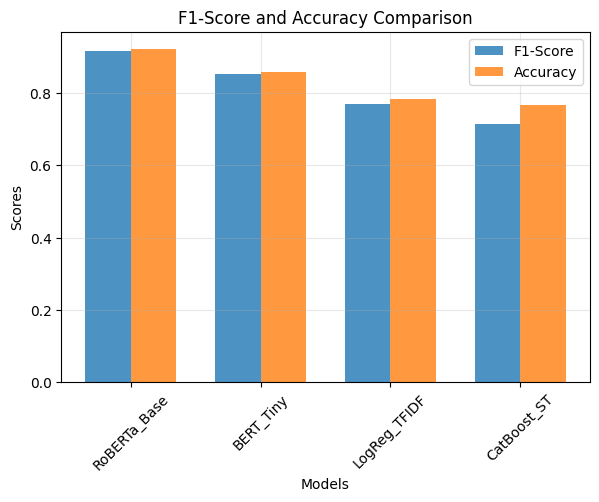

In [15]:
plt.figure(figsize=(15, 10))

# F1-Score и Accuracy
plt.subplot(2, 2, 1)
models = comparison_df['Model']
f1_scores = comparison_df['F1-Score']
acc_scores = comparison_df['Accuracy']

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, f1_scores, width, label='F1-Score', alpha=0.8)
plt.bar(x + width/2, acc_scores, width, label='Accuracy', alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('F1-Score and Accuracy Comparison')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Время обучения

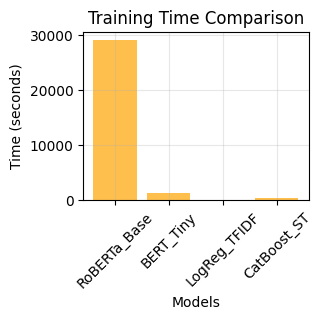

In [16]:
plt.subplot(2, 2, 2)
plt.bar(models, comparison_df['Training_Time_s'], color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Training Time Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Время предсказания

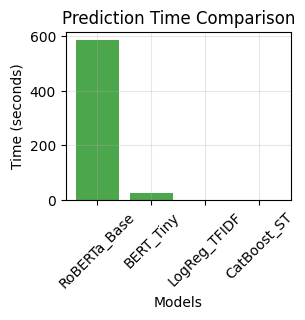

In [17]:
plt.subplot(2, 2, 3)
plt.bar(models, comparison_df['Prediction_Time_s'], color='green', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.title('Prediction Time Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# ВЫБОР И СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ

In [25]:
print("Доступные ключи в best_model_metrics:", list(best_model_metrics.keys()))

Доступные ключи в best_model_metrics: ['model', 'tokenizer', 'f1', 'accuracy', 'train_time', 'pred_time', 'predictions']


In [33]:
print("💾 СОХРАНЕНИЕ LOGREG_TFIDF ДЛЯ ПРЕДСКАЗАНИЙ")

# Получаем модель и векторизатор из results
best_model_metrics = results['LogReg_TFIDF']

lr_model = best_model_metrics['model']
tfidf = best_model_metrics['vectorizer']

💾 СОХРАНЕНИЕ LOGREG_TFIDF ДЛЯ ПРЕДСКАЗАНИЙ


In [37]:
print("📦 Сохраняем компоненты модели...")
import datetime
import sklearn

model_package = {
    'model': lr_model,
    'vectorizer': tfidf,
    'metadata': {
        'model_name': 'LogReg_TFIDF',
        'f1_score': best_model_metrics['f1'],
        'accuracy': best_model_metrics['accuracy'],
        'train_time': best_model_metrics['train_time'],
        'pred_time': best_model_metrics['pred_time'],
        'saved_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'sklearn_version': sklearn.__version__,
        'feature_type': 'TF-IDF',
        'ngram_range': '(1, 2)',
        'max_features': 10000
    }
}
joblib.dump(model_package, './models/logreg_tfidf_package.joblib')


📦 Сохраняем компоненты модели...


['./models/logreg_tfidf_package.joblib']

In [38]:
with open('./models/model_info.txt', 'w', encoding='utf-8') as f:
    f.write("=== LOGREG_TFIDF MODEL INFO ===\n\n")
    f.write(f"Сохранено: {datetime.datetime.now()}\n\n")
    f.write("МЕТРИКИ:\n")
    f.write(f"  F1-Score: {best_model_metrics['f1']:.4f}\n")
    f.write(f"  Accuracy: {best_model_metrics['accuracy']:.4f}\n")
    f.write(f"  Training Time: {best_model_metrics['train_time']:.2f} сек\n")
    f.write(f"  Prediction Time: {best_model_metrics['pred_time']:.4f} сек\n\n")
    f.write("ПАРАМЕТРЫ TF-IDF:\n")
    f.write("  max_features: 10000\n")
    f.write("  ngram_range: (1, 2)\n")
    f.write("  stop_words: english\n\n")
    f.write("СОХРАНЕННЫЕ ФАЙЛЫ:\n")
    f.write("  lr_model.joblib - модель Logistic Regression\n")
    f.write("  tfidf_vectorizer.joblib - TF-IDF векторизатор\n")
    f.write("  logreg_tfidf_package.joblib - полный пакет\n")
    f.write("  model_info.txt - эта информация\n")

print("✅ Модель LogReg_TFIDF сохранена для предсказаний!")
print(f"📊 F1-Score: {best_model_metrics['f1']:.4f}")
print(f"🎯 Accuracy: {best_model_metrics['accuracy']:.4f}")
print("\n📁 Сохраненные файлы:")
print("  - lr_model.joblib")
print("  - tfidf_vectorizer.joblib")
print("  - logreg_tfidf_package.joblib")
print("  - model_info.txt")

✅ Модель LogReg_TFIDF сохранена для предсказаний!
📊 F1-Score: 0.7717
🎯 Accuracy: 0.7834

📁 Сохраненные файлы:
  - lr_model.joblib
  - tfidf_vectorizer.joblib
  - logreg_tfidf_package.joblib
  - model_info.txt


Обучено 4 модели 

1. 🔵 Logistic Regression + TF-IDF (Classic ML)
 ✅ F1-score: 0.7717
- Accuracy: 0.7834
- Время обучения: 5.62 сек
- Время предсказания: 0.0010 сек
- Алгоритм: Линейная классификация")
- Векторизация: TF-IDF с n-граммами (1,2)")
- Преимущества: Быстрая, интерпретируемая, хороший baseline
- Использование: Обучение на TF-IDF features
  
2. 🐱 CatBoost + SentenceTransformer (Ensemble + Embeddings(худшая модель)
✅ F1-score: 0.7153
- Accuracy: 0.7681
- Время обучения: 293.38 сек
- Время предсказания: 0.1402 сек
- 
- Алгоритм: Градиентный бустинг")
- Эмбеддинги: SentenceTransformer (all-MiniLM-L6-v2)")
- Преимущества: Мощный, handles categorical features")
- Использование: Обучение на текстовых эмбеддингах")

3. 🤖 BERT-Tiny (Transformer-based)
✅ F1-score: 0.8548
- Accuracy: 0.8586
- Время обучения: 1172.37 сек
- Время предсказания: 25.6113 сек
  
- Архитектура: Миниатюрная версия BERT
- Параметры: ~4.4M параметров
- Преимущества: Быстрая, легкая, хорошее качество
- Использование: Fine-tuning на датасете сарказма

4. 🦾 RoBERTa-Base (Transformer-based)(показала лучшие метрики, но очень долгая)
✅F1-score: 0.9166
- Accuracy: 0.9239
- Время обучения: 29130.66 сек
- Время предсказания: 586.0125 сек

- Архитектура: Оптимизированная версия BERT
- Параметры: ~125M параметров
- Преимущества: Высокое качество, robust representations
- Использование: Fine-tuning на датасете сарказма
 

📈 МЕТРИКИ ОЦЕНКИ:
• Основные: F1-Score, Accuracy, Precision, Recall
• Временные: Время обучения, время инференса
• Дополнительные: Уверенность предсказаний, ROC-AUC

🛠️  ТЕХНОЛОГИЧЕСКИЙ СТЕК:
• Фреймворки: PyTorch, Transformers, Scikit-learn, CatBoost
• Обработка текста: NLTK, SentenceTransformers, TF-IDF
• Модели: BERT, RoBERTa, Logistic Regression, Gradient Boosting
• Инструменты: Hugging Face, Datasets, Evaluate

Сравнили метрики (F1, Accuracy, время)

Создали визуализации для сравнения

Сгенерировали отчеты и сохранили все файлы